In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class SpendObject:
    '''Defines a body of spending based on a period of launches (cohorts), each based on a fundamental profile and cohort growth
    (i.e. change in magnitude of profile over successive cohorts).
    The period for calculating spend is open:  the last period in the profile is taken to be the "terminal" spend,
    which changes according to the terminal growth rate (this would normally be negative).
    '''
    def __init__(self, profile, launch_pers, coh_growth=0, term_growth=0):
        self.profile = profile
        self.launch_pers = launch_pers
        self.prof_len = len(profile)
        self.coh_growth = coh_growth
        self.term_growth = term_growth
        self.term_value = profile[-1]
        width = 40
        self.info = {"launch periods": self.launch_pers,
                     "profile length": len(self.profile)}

    # Takes a point in time (eg a year or other period), and calculates spend in that period on all cohorts
    # (i.e. launches from a given period eg year)   
    
            
    def _spender(self, spend_per, debug=False):
        
        # NB - USES ZERO-BASED INDEXING FOR EVERYTHING
        
        # First, define the frame by going back from the spend period by the number of launch periods
        # This must give the actual indexes of the relevant elements of the profile for iterating
        # Zero based, and wants to go one past the end (that's how iteration works)
        
        frame = (max(0, spend_per - self.launch_pers), spend_per+1)   
        
            # eg if spend_per is 5 (i.e. 6 periods) and there are 2 cohorts, then want indices 4-5, so frame is (3,6)
            # DON'T UNDERSTAND WHY DON'T NEED TO ADD ONE TO SPEND_PER TO MAKE GO OFF END
        
        f_start, f_end = frame
        last_coh = min(self.launch_pers, spend_per) # minus 1 to make zero based
        
        if debug:
            print("frame ", frame, "cohorts ", last_coh+1)
            titles = "prof point, coh id, raw val, coh adj, term adj, total adj,   val".split(",")
            pads = [len(t)-1 for t in titles]
            print(" |".join(titles))

        # Now iterate through the frame (i.e. through the cohorts), yielding the spend at the corresponding profile point,
        # adjusted as necessary.  If the profile point is beyond the terminal, then calculate appropriately
       
        for i, prof_point in enumerate(range(f_start, f_end)):
            
            # It helps to know which cohort we're on.  The last period in the frame corresponds to the zeroth cohort.
            # So the first will correspond to the last launch period (minus 1 to make start at zero).  
            # Then iterate through with the index
            coh_id = last_coh - i
            coh_adj = (1+self.coh_growth)**coh_id # used to adjust for growth between cohorts
            
            if debug: print(str(prof_point).rjust(pads[0]+1), "|", 
                            str(coh_id).rjust(pads[1]), "|", end="") 
                            
            
            # As long as the period is within the profile, yield the corresponding profile point
            if prof_point < self.prof_len: # length is one past the last index, so this is True for terminal profile point
                val = self.profile[prof_point] * coh_adj # adjust for cohort growth
                
                if debug: print(str(self.profile[prof_point]).rjust(pads[2]), " |", 
                                  "{0:.3f}".format(coh_adj).rjust(pads[3]),  "|",
                                  "-".rjust(pads[4]), "|", 
                                  "{0:.3f}".format(coh_adj).rjust(pads[5]), "|", 
                                  "{0:.3f}".format(val).rjust(pads[6])) 
                yield val
            
            # If the period is beyond the profile, use the terminal value
            else:
                # adjust the terminal value by the cohort growth, then acc to the number of periods post terminal
                term_adj = (1+self.term_growth)**(prof_point - self.prof_len+1)
                val = self.term_value * coh_adj * term_adj
                if debug: print(str(self.term_value).rjust(pads[2]), " |", 
                                  "{0:.3f}".format(coh_adj).rjust(pads[3]),  "|",
                                  "{0:.3f}".format(term_adj).rjust(pads[4]), "|", 
                                  "{0:.3f}".format(term_adj*coh_adj).rjust(pads[5]), "|", 
                                  "{0:.3f}".format(val).rjust(pads[6])) 
                yield val
                
    def point_spend(self, spend_per):
        return sum(self._spender(spend_per))
    
    def __getitem__(self, sl):
        # test if it's a single index, rather than a slice
        if isinstance(sl,int):
            return sum(self._spender(sl))
        else:
            slice_out = []
            for i in range(sl.start, sl.stop):
                slice_out.append(sum(self._spender(i)))
            return slice_out
    
    def get_np(self, max_per, debug=False):
        np_out_list = []
        if debug: print(self.info)
        for i, per in enumerate(range(max_per)):
            if debug: print("\nGetting period ", per)
            res = sum(self._spender(per, debug))
            if debug: print("Period ", per, "result ", res)
            np_out_list.append(res)
        return(np.array(np_out_list))
    

test_profile = np.array([1,2,5,10,11,12,1])
coh0 = SpendObject(test_profile, 5, 0.1, -0.1)
coh0.info

{'launch periods': 5, 'profile length': 7}

In [4]:
coh0.get_np(10, debug=True)

{'launch periods': 5, 'profile length': 7}

Getting period  0
frame  (0, 1) cohorts  1
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      0 |      1  |   1.000 |        - |     1.000 | 1.000
Period  0 result  1.0

Getting period  1
frame  (0, 2) cohorts  2
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      1 |      1  |   1.100 |        - |     1.100 | 1.100
         1 |      0 |      2  |   1.000 |        - |     1.000 | 2.000
Period  1 result  3.1

Getting period  2
frame  (0, 3) cohorts  3
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      2 |      1  |   1.210 |        - |     1.210 | 1.210
         1 |      1 |      2  |   1.100 |        - |     1.100 | 2.200
         2 |      0 |      5  |   1.000 |        - |     1.000 | 5.000
Period  2 result  8.41

Getting period  3
frame  (0, 4) cohorts  4
prof point | coh id | raw val | coh adj | term adj | total adj |   val
    

array([  1.     ,   3.1    ,   8.41   ,  19.251  ,  32.1761 ,  47.39371,
        51.36152,  53.85455,  51.1922 ,  39.32481])

In [122]:
new_coh = SpendObject(test_profile, 5, 0.1, -0.1)

new_coh.get_np(20, debug=True)

{'launch periods': 5, 'profile length': 7}

Getting period  0
frame  (0, 1) cohorts  1
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      0 |      1  |   1.000 |        - |     1.000 | 1.000
Period  0 result  1.0

Getting period  1
frame  (0, 2) cohorts  2
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      1 |      1  |   1.100 |        - |     1.100 | 1.100
         1 |      0 |      2  |   1.000 |        - |     1.000 | 2.000
Period  1 result  3.1

Getting period  2
frame  (0, 3) cohorts  3
prof point | coh id | raw val | coh adj | term adj | total adj |   val
         0 |      2 |      1  |   1.210 |        - |     1.210 | 1.210
         1 |      1 |      2  |   1.100 |        - |     1.100 | 2.200
         2 |      0 |      5  |   1.000 |        - |     1.000 | 5.000
Period  2 result  8.41

Getting period  3
frame  (0, 4) cohorts  4
prof point | coh id | raw val | coh adj | term adj | total adj |   val
    

array([  1.        ,   3.1       ,   8.41      ,  19.251     ,
        32.1761    ,  47.39371   ,  51.36152   ,  53.85455   ,
        51.1922    ,  39.32481   ,  24.42622   ,   6.2006    ,
         5.58054   ,   5.022486  ,   4.5202374 ,   4.06821366,
         3.66139229,   3.29525306,   2.96572776,   2.66915498])

In [123]:
new_coh[8]

51.192200000000028

In [367]:
coh1.coh_growth

0.1

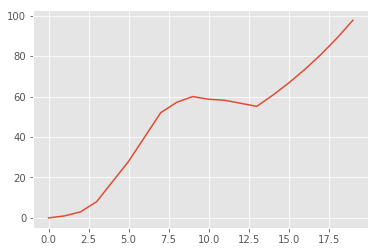

In [363]:
plt.plot(coh0.get_np(20))

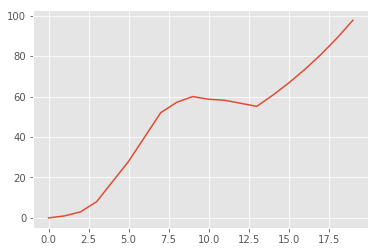

In [364]:
plt.plot(coh1.get_np(20))

In [347]:
coh.get_np(20)

array([  0.        ,   1.        ,   3.        ,   8.        ,
        18.        ,  28.        ,  40.        ,  52.        ,
        57.15      ,  60.015     ,  58.6665    ,  58.18315   ,
        56.651465  ,  55.1666115 ,  60.68327265,  66.75159992,
        73.42675991,  80.7694359 ,  88.84637949,  97.73101744])

In [159]:
coh[5:10]

slice(5, 10, None)


[29, 41, 53, 57.5, 59.0]

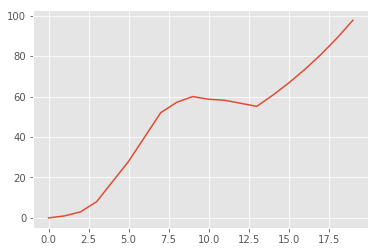

In [348]:
out_list1 = []
for x in range(20):
    out_list1.append(coh.point_spend(x))
plt.plot(out_list1)

In [349]:
launches_list = list(range(5, 10, 1))
objs_out = []
for launch in launches_list:
    cohx = SpendObject(test_profile, launch)
    objs_out.append(cohx)
    

In [350]:
nps_out = []
for obj in objs_out:
    nps_out.append(obj.get_np(20))


In [351]:
len(nps_out)

5

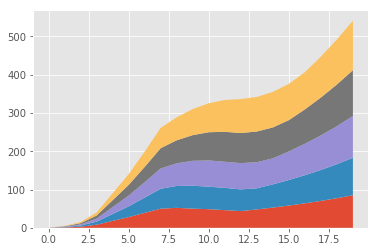

In [352]:
plt.style.use('ggplot')
plt.stackplot(range(0,20),nps_out)

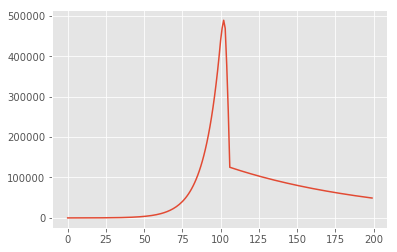

In [444]:
coh = SpendObject(test_profile, 100, 0.1, -0.01)
plt.plot(coh.get_np(200))
